# Preparación

In [1]:
from ETL_pg2neo4j.diagnostics import get_machine_stats
from ETL_pg2neo4j.spark_session import get_spark
from ETL_pg2neo4j.load_config import (
    NEO4J_URI, NEO4J_USER, NEO4J_PASS, NEO4J_DDBB
)

stats = get_machine_stats()
spark, jdbc_props = get_spark(stats)

opts = { #Alternativa a cargar desde la sesión de spark
    "url": NEO4J_URI,
    "authentication.type": "basic",
    "authentication.basic.username": NEO4J_USER,
    "authentication.basic.password": NEO4J_PASS,
    "database": NEO4J_DDBB  
}

[SPARK] usando jars locales -> /opt/spark/extra-jars/postgresql-42.7.4.jar,/opt/spark/extra-jars/neo4j-connector-apache-spark_2.12-5.3.10_for_spark_3.jar
[SPARK] classpath reforzado (driver/executors) -> /opt/spark/extra-jars/postgresql-42.7.4.jar:/opt/spark/extra-jars/neo4j-connector-apache-spark_2.12-5.3.10_for_spark_3.jar


ERROR StatusLogger Reconfiguration failed: No configuration found for '5ffd2b27' at 'null' in 'null'
ERROR StatusLogger Reconfiguration failed: No configuration found for 'Default' at 'null' in 'null'
25/11/24 09:20:58 WARN Utils: Your hostname, AsusMare resolves to a loopback address: 127.0.1.1; using 192.168.100.4 instead (on interface wlp2s0)
25/11/24 09:20:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/11/24 09:20:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/24 09:20:59 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


[CHECK] Postgres JDBC REALMENTE visible
[CHECK] Neo4j connector REALMENTE visible


In [2]:
# Query Cypher para nodos: trae solo lo que te interesa ahora
node_query = """
MATCH (a:Account)
RETURN
    id(a)                  AS neo4j_id,
    a.account_number       AS account_number,
    a.location             AS location,
    a.current_balance      AS current_balance,
    a.first_seen           AS first_seen,
    a.last_seen            AS last_seen
"""

nodes_df = (
    spark.read
        .format("org.neo4j.spark.DataSource")
        .option("url", NEO4J_URI)
        .option("authentication.type", "basic")
        .option("authentication.basic.username", NEO4J_USER)
        .option("authentication.basic.password", NEO4J_PASS)
        .option("database", NEO4J_DDBB)
        .option("query", node_query)
        .load()
)

nodes_df.printSchema()
nodes_df.show(5)


root
 |-- neo4j_id: long (nullable = true)
 |-- account_number: long (nullable = true)
 |-- location: string (nullable = true)
 |-- current_balance: double (nullable = true)
 |-- first_seen: timestamp (nullable = true)
 |-- last_seen: timestamp (nullable = true)

+--------+--------------+--------+------------------+-------------------+-------------------+
|neo4j_id|account_number|location|   current_balance|         first_seen|          last_seen|
+--------+--------------+--------+------------------+-------------------+-------------------+
|       0|    4651102136|      UK|51445.619999999995|2023-03-17 21:35:31|2023-03-18 18:45:28|
|       1|    3647155427|      UK|         -68020.94|2023-03-10 06:34:09|2023-03-10 20:02:05|
|       2|    8986636663|      UK|2804.2599999999998|2022-10-27 06:16:50|2023-05-20 08:41:51|
|       3|     196361780|      UK|         131638.48|2022-10-17 16:03:31|2023-07-07 13:12:55|
|       4|    3775525103|      UK|           15667.7|2022-11-06 08:09:43|2023-

In [3]:
edge_query = """
MATCH (src:Account)-[r:TX]->(dst:Account)
RETURN
    id(r)                        AS neo4j_rel_id,
    r.id                         AS id,
    src.account_number           AS src,
    dst.account_number           AS dst,
    r.timestamp                  AS timestamp,
    r.amount                     AS amount,
    r.payment_currency           AS payment_currency,
    r.received_currency          AS received_currency,
    r.payment_type               AS payment_type,
    r.is_laundering              AS is_laundering,
    r.laundering_type            AS laundering_type,
    r.masked                     AS masked,
    r.src_delta                  AS src_delta,
    r.src_balance_before         AS src_balance_before,
    r.src_balance_after          AS src_balance_after,
    r.src_seq                    AS src_seq,
    r.src_currency               AS src_currency,
    r.dst_delta                  AS dst_delta,
    r.dst_balance_before         AS dst_balance_before,
    r.dst_balance_after          AS dst_balance_after,
    r.dst_seq                    AS dst_seq,
    r.dst_currency               AS dst_currency
"""

edges_df = (
    spark.read
        .format("org.neo4j.spark.DataSource")
        .option("url", NEO4J_URI)
        .option("authentication.type", "basic")
        .option("authentication.basic.username", NEO4J_USER)
        .option("authentication.basic.password", NEO4J_PASS)
        .option("database", NEO4J_DDBB)
        .option("query", edge_query)
        .load()
)

edges_df.printSchema()
edges_df.show(5)


root
 |-- neo4j_rel_id: long (nullable = true)
 |-- id: long (nullable = true)
 |-- src: long (nullable = true)
 |-- dst: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- amount: double (nullable = true)
 |-- payment_currency: string (nullable = true)
 |-- received_currency: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- is_laundering: long (nullable = true)
 |-- laundering_type: string (nullable = true)
 |-- masked: long (nullable = true)
 |-- src_delta: double (nullable = true)
 |-- src_balance_before: double (nullable = true)
 |-- src_balance_after: double (nullable = true)
 |-- src_seq: long (nullable = true)
 |-- src_currency: string (nullable = true)
 |-- dst_delta: double (nullable = true)
 |-- dst_balance_before: double (nullable = true)
 |-- dst_balance_after: double (nullable = true)
 |-- dst_seq: long (nullable = true)
 |-- dst_currency: string (nullable = true)

+-------------------+-------+----------+----------+------------

# Grados y hubs

## Métricas básicas por nodo

In [4]:
from pyspark.sql import functions as F

# --- OUT: métricas como emisor (src) ---
out_stats = (
    edges_df
    .groupBy("src")
    .agg(
        F.count("*").alias("out_degree"),
        F.sum("amount").alias("out_amount_sum"),
        F.sum("is_laundering").alias("fraud_out_count")  # is_laundering es 0/1
    )
)

# --- IN: métricas como receptor (dst) ---
in_stats = (
    edges_df
    .groupBy("dst")
    .agg(
        F.count("*").alias("in_degree"),
        F.sum("amount").alias("in_amount_sum"),
        F.sum("is_laundering").alias("fraud_in_count")
    )
)


In [5]:
# Partimos de los atributos "básicos" que sí nos interesan
base_nodes = nodes_df.select(
    "account_number",
    "location",
    "current_balance",
    "first_seen",
    "last_seen"
)

node_metrics_df = (
    base_nodes
    # join con estadísticas de salida
    .join(out_stats, base_nodes.account_number == out_stats.src, "left")
    # join con estadísticas de entrada
    .join(in_stats, base_nodes.account_number == in_stats.dst, "left")
    .drop("src", "dst")
)

# Rellenar los nulls (cuentas que nunca emitieron/recibieron algo) con 0
numeric_cols = [
    "out_degree", "out_amount_sum", "fraud_out_count",
    "in_degree", "in_amount_sum", "fraud_in_count"
]

for c in numeric_cols:
    node_metrics_df = node_metrics_df.withColumn(
        c, F.coalesce(F.col(c), F.lit(0.0))
    )

# Cast a tipos más "bonitos" donde toque (los counts como long/int)
node_metrics_df = (
    node_metrics_df
    .withColumn("out_degree", F.col("out_degree").cast("long"))
    .withColumn("in_degree", F.col("in_degree").cast("long"))
    .withColumn("fraud_out_count", F.col("fraud_out_count").cast("long"))
    .withColumn("fraud_in_count", F.col("fraud_in_count").cast("long"))
)


In [6]:
node_metrics_df = (
    node_metrics_df
    .withColumn(
        "fraud_out_ratio",
        F.when(F.col("out_degree") > 0,
               F.col("fraud_out_count") / F.col("out_degree"))
         .otherwise(F.lit(0.0))
    )
    .withColumn(
        "fraud_in_ratio",
        F.when(F.col("in_degree") > 0,
               F.col("fraud_in_count") / F.col("in_degree"))
         .otherwise(F.lit(0.0))
    )
)


## Vecinos y vecinos fraudulentos

In [7]:
#Vecinos totales
# Aristas no dirigidas (a,b) y (b,a), sin duplicados
edges_undirected = (
    edges_df
    .select(F.col("src").alias("a"), F.col("dst").alias("b"))
    .unionByName(
        edges_df.select(F.col("dst").alias("a"), F.col("src").alias("b"))
    )
    .dropDuplicates()
)

neighbors = (
    edges_undirected
    .groupBy("a")
    .agg(F.countDistinct("b").alias("neighbors_count"))
)


In [8]:
#Vecinos con al menos un enlace fraudulento
fraud_edges_undirected = (
    edges_df
    .filter(F.col("is_laundering") == 1)
    .select(F.col("src").alias("a"), F.col("dst").alias("b"))
    .unionByName(
        edges_df
        .filter(F.col("is_laundering") == 1)
        .select(F.col("dst").alias("a"), F.col("src").alias("b"))
    )
    .dropDuplicates()
)

fraud_neighbors = (
    fraud_edges_undirected
    .groupBy("a")
    .agg(F.countDistinct("b").alias("fraud_neighbors_count"))
)


In [9]:
node_metrics_df = (
    node_metrics_df
    .join(neighbors, node_metrics_df.account_number == neighbors.a, "left")
    .join(fraud_neighbors, node_metrics_df.account_number == fraud_neighbors.a, "left")
    .drop("a")
)

node_metrics_df = (
    node_metrics_df
    .withColumn("neighbors_count", F.coalesce(F.col("neighbors_count"), F.lit(0)))
    .withColumn("fraud_neighbors_count", F.coalesce(F.col("fraud_neighbors_count"), F.lit(0)))
    .withColumn(
        "fraud_neighbors_ratio",
        F.when(F.col("neighbors_count") > 0,
               F.col("fraud_neighbors_count") / F.col("neighbors_count"))
         .otherwise(F.lit(0.0))
    )
)


In [10]:
node_metrics_df.select(
    "in_degree", "out_degree",
    "in_amount_sum", "out_amount_sum",
    "fraud_in_ratio", "fraud_out_ratio",
    "neighbors_count", "fraud_neighbors_ratio"
).summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show(truncate=False)


25/11/24 09:23:33 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 26:>                                                         (0 + 1) / 1]

+-------+------------------+------------------+------------------+-----------------+---------------------+-------------------+------------------+---------------------+
|summary|in_degree         |out_degree        |in_amount_sum     |out_amount_sum   |fraud_in_ratio       |fraud_out_ratio    |neighbors_count   |fraud_neighbors_ratio|
+-------+------------------+------------------+------------------+-----------------+---------------------+-------------------+------------------+---------------------+
|count  |855460            |855460            |855460            |855460           |855460               |855460             |855460            |855460               |
|mean   |11.110808220138873|11.110808220138873|97363.65245319254 |97363.65245319293|0.0015532081593782822|3.79021782102301E-4|1.9652116989689759|0.0018401598192986234|
|stddev |27.02063620269903 |55.75791563599599 |281141.07274827536|459051.6994912461|0.03469331988431024  |0.01035075493637477|6.494315089979579 |0.0329752019288

In [11]:
deg_dist = (
    node_metrics_df
    .withColumn(
        "out_degree_bin",
        F.when(F.col("out_degree") == 0, "0")
         .otherwise(
             F.concat(
                 F.lit("1e"),
                 F.floor(F.log10("out_degree")).cast("int")  # 1e0, 1e1, 1e2...
             )
         )
    )
    .groupBy("out_degree_bin")
    .count()
    .orderBy("out_degree_bin")
)

deg_dist.show(truncate=False)


+--------------+------+
|out_degree_bin|count |
+--------------+------+
|0             |562745|
|1e0           |75997 |
|1e1           |198174|
|1e2           |18544 |
+--------------+------+



In [12]:
def add_degree_bins(df, col_name, bin_col_name):
    return (
        df.withColumn(
            bin_col_name,
            F.when(F.col(col_name) == 0, "0")
             .when(F.col(col_name) == 1, "1")
             .when((F.col(col_name) >= 2) & (F.col(col_name) <= 5), "2–5")
             .when((F.col(col_name) >= 6) & (F.col(col_name) <= 10), "6–10")
             .when((F.col(col_name) >= 11) & (F.col(col_name) <= 20), "11–20")
             .when((F.col(col_name) >= 21) & (F.col(col_name) <= 50), "21–50")
             .when((F.col(col_name) >= 51) & (F.col(col_name) <= 100), "51–100")
             .when((F.col(col_name) >= 101) & (F.col(col_name) <= 200), "101–200")
             .otherwise(">200")
        )
    )

# Añadimos bins para in/out degree
node_binned_df = (
    node_metrics_df
    .transform(lambda df: add_degree_bins(df, "out_degree", "out_degree_bin"))
    .transform(lambda df: add_degree_bins(df, "in_degree", "in_degree_bin"))
)

# Distribución de out_degree
out_deg_dist_spark = (
    node_binned_df
    .groupBy("out_degree_bin")
    .count()
    .orderBy("out_degree_bin")
)

# Distribución de in_degree
in_deg_dist_spark = (
    node_binned_df
    .groupBy("in_degree_bin")
    .count()
    .orderBy("in_degree_bin")
)


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

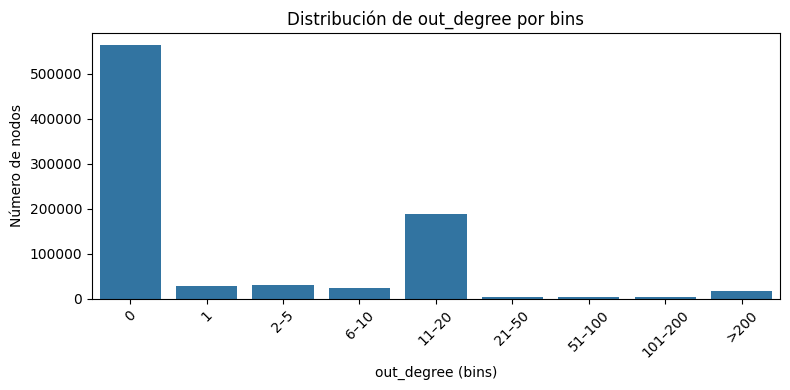

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

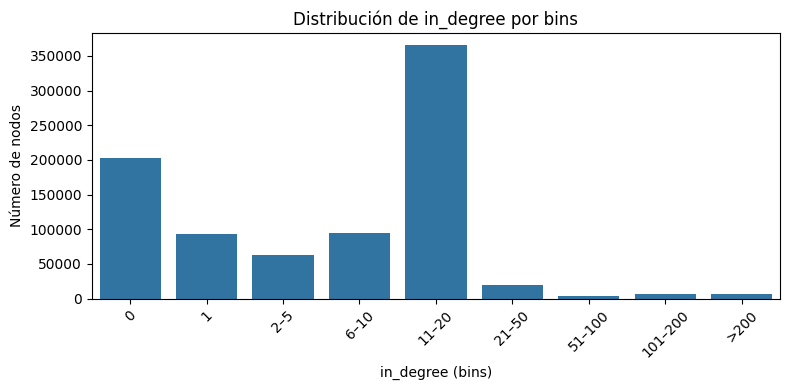

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

deg_bins_order = ["0", "1", "2–5", "6–10", "11–20", "21–50", "51–100", "101–200", ">200"]

# OUT DEGREE
out_deg_dist = out_deg_dist_spark.toPandas()
cat_type_out = pd.CategoricalDtype(categories=deg_bins_order, ordered=True)
out_deg_dist["out_degree_bin"] = out_deg_dist["out_degree_bin"].astype(cat_type_out)
out_deg_dist = out_deg_dist.sort_values("out_degree_bin")

plt.figure(figsize=(8,4))
sns.barplot(
    data=out_deg_dist,
    x="out_degree_bin",
    y="count"
)
plt.title("Distribución de out_degree por bins")
plt.xlabel("out_degree (bins)")
plt.ylabel("Número de nodos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# IN DEGREE
in_deg_dist = in_deg_dist_spark.toPandas()
cat_type_in = pd.CategoricalDtype(categories=deg_bins_order, ordered=True)
in_deg_dist["in_degree_bin"] = in_deg_dist["in_degree_bin"].astype(cat_type_in)
in_deg_dist = in_deg_dist.sort_values("in_degree_bin")

plt.figure(figsize=(8,4))
sns.barplot(
    data=in_deg_dist,
    x="in_degree_bin",
    y="count"
)
plt.title("Distribución de in_degree por bins")
plt.xlabel("in_degree (bins)")
plt.ylabel("Número de nodos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
# Tomar, por ejemplo, el 10% de los nodos (o un límite de filas)
sample_df = node_metrics_df.sample(withReplacement=False, fraction=0.1, seed=42)

sample_pd = sample_df.select(
    "in_degree", "out_degree",
    "in_amount_sum", "out_amount_sum",
    "fraud_in_ratio", "fraud_out_ratio",
    "neighbors_count", "fraud_neighbors_ratio"
).toPandas()

sample_pd.describe(percentiles=[0.25, 0.5, 0.75]).T  # se ve muy legible en Jupyter


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,count,mean,std,min,25%,50%,75%,max
in_degree,85828.0,11.104814,27.028108,0.0,1.0000,9.00,13.0000,7.300000e+02
out_degree,85828.0,11.063301,55.584429,0.0,0.0000,0.00,10.0000,7.420000e+02
in_amount_sum,85828.0,98179.820361,283783.671475,0.0,942.6725,23739.39,99034.6700,1.439340e+07
out_amount_sum,85828.0,97172.025458,459192.580207,0.0,0.0000,0.00,59270.7625,1.372392e+07
fraud_in_ratio,85828.0,0.001657,0.036405,0.0,0.0000,0.00,0.0000,1.000000e+00
fraud_out_ratio,85828.0,0.000367,0.009102,0.0,0.0000,0.00,0.0000,6.666667e-01
neighbors_count,85828.0,1.960596,6.465982,1.0,1.0000,1.00,1.0000,7.600000e+01
fraud_neighbors_ratio,85828.0,0.001972,0.034782,0.0,0.0000,0.00,0.0000,1.000000e+00


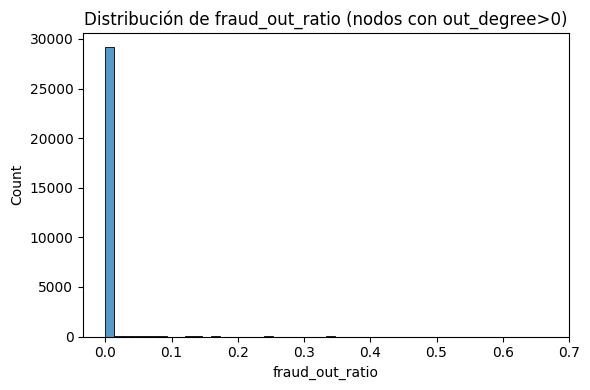

In [15]:
plt.figure(figsize=(6,4))
sns.histplot(
    data=sample_pd[sample_pd["out_degree"] > 0], 
    x="fraud_out_ratio",
    bins=50
)
plt.title("Distribución de fraud_out_ratio (nodos con out_degree>0)")
plt.tight_layout()
plt.show()

Más de 500k cuentas con out_degree 0, nunca envían dinero. El resto se reparte en bins crecientes con solo una minoría de con out_degree alto. La moda del set es que las cuentas envíen entre 11 a 20 transferencias si es que son activas. La mayoría (moda real) no lo son.

Muchísima más masa hasta las 20 transacciones. Recibir dinero es mucho más común que enviarlo. El promedio de vecinos por nodo es de 2 por lo que la conectividad parece pequeña.

Ratios de fraude (fraud_in_ratio, fraud_out_ratio) tienen medias bajísimas, pero con colas que llegan a 1 lo que implica que hay cuentas completamente asociadas a fraude. Esto valida los hubs elegidos en el EDA temporal. Sin embargo, ese ejercicio carece de peso estadístico por la baja cantidad de hubs elegidos. Aún así, es un buen ejercicio, pues señala diferencias entre nodos y nodos.

## Montos

In [16]:
node_metrics_df = (
    node_metrics_df
    # montos promedio (evita división por cero)
    .withColumn(
        "out_avg_amount",
        F.when(F.col("out_degree") > 0,
               F.col("out_amount_sum") / F.col("out_degree"))
         .otherwise(F.lit(0.0))
    )
    .withColumn(
        "in_avg_amount",
        F.when(F.col("in_degree") > 0,
               F.col("in_amount_sum") / F.col("in_degree"))
         .otherwise(F.lit(0.0))
    )
    # logs de sumas (log10(x+1) para soportar 0)
    .withColumn(
        "log_out_amount_sum",
        F.log10(F.col("out_amount_sum") + F.lit(1.0))
    )
    .withColumn(
        "log_in_amount_sum",
        F.log10(F.col("in_amount_sum") + F.lit(1.0))
    )
)


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

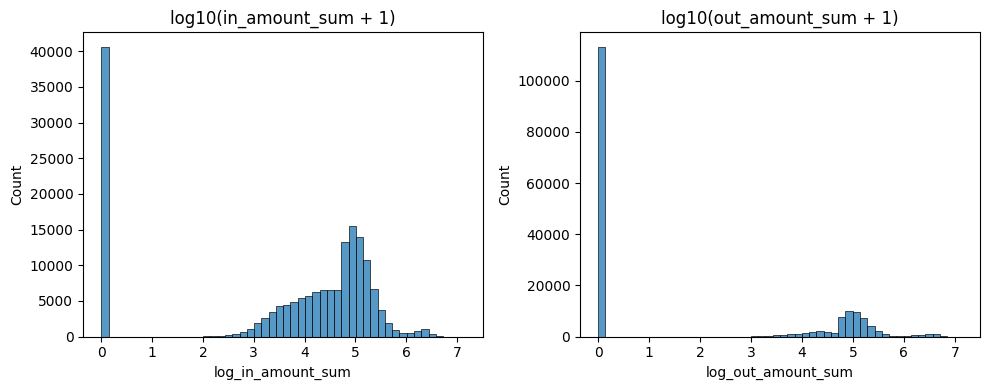

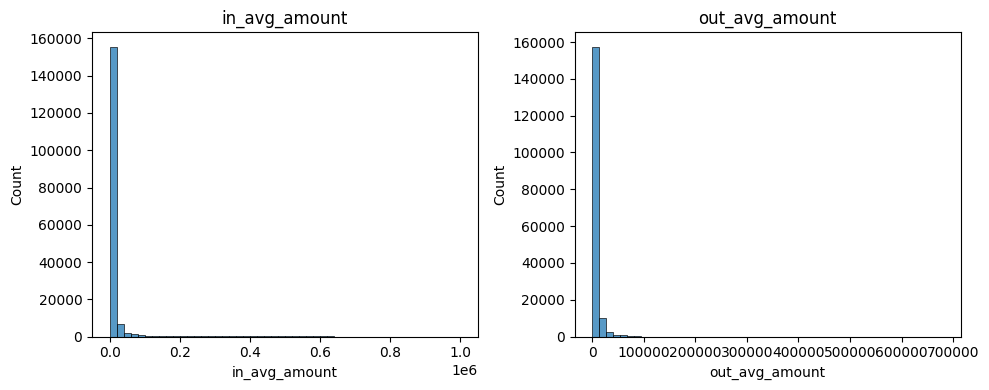

In [17]:
sample_df = node_metrics_df.sample(withReplacement=False, fraction=0.2, seed=42)

sample_pd = sample_df.select(
    "log_in_amount_sum", "log_out_amount_sum",
    "in_amount_sum", "out_amount_sum",
    "in_avg_amount", "out_avg_amount"
).toPandas()

# histograma logs sumas
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(sample_pd["log_in_amount_sum"], bins=50)
plt.title("log10(in_amount_sum + 1)")

plt.subplot(1,2,2)
sns.histplot(sample_pd["log_out_amount_sum"], bins=50)
plt.title("log10(out_amount_sum + 1)")

plt.tight_layout()
plt.show()

# histograma montos promedio
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(sample_pd["in_avg_amount"], bins=50)
plt.title("in_avg_amount")

plt.subplot(1,2,2)
sns.histplot(sample_pd["out_avg_amount"], bins=50)
plt.title("out_avg_amount")

plt.tight_layout()
plt.show()


Entre los picos en 0 están los que nunca recibieron in_amount ni los que nunca enviaron out_amount como se observó con los grados. Los histogramas en logaritmo tienen suficiente resolución como para descubrir mini campanas con mayor actividad entre 4 y 6, es decir con montos entre 10⁴ a 10⁶, hay, eso sí, un par de colas que llegan hasta 10⁷- En otras palabras hay una gran cantidad de cuentas con muy poca actividad, o básicamente sin actividad, y otro grupo pequeño que concentra actividad en montos totales muy grandes. 

Los histogramas de promedio están sumamente sesgados: un pico brutal en cero, y rangos altos de montos promedio donde se ve actividad aunque sea minúscula, es decir, una cola larguísima hacia la derecha. En otras palabras, la mayoría de las cuentas del dataset operan con valores "normales", mientras que un grupo reducido opera a grandes volúmenes, donde cada transacción promedio es enorme, tanto de entrada como de salida. 

En otras palabras, se pueden observar dos tipos de cuentas:
- Cuentas con muchas transacciones (alto grado) pero montos medios moderados
- Cuentas con pocas transacciones pero con montos medios gigantes

## Bivariado 1: grado vs monto

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

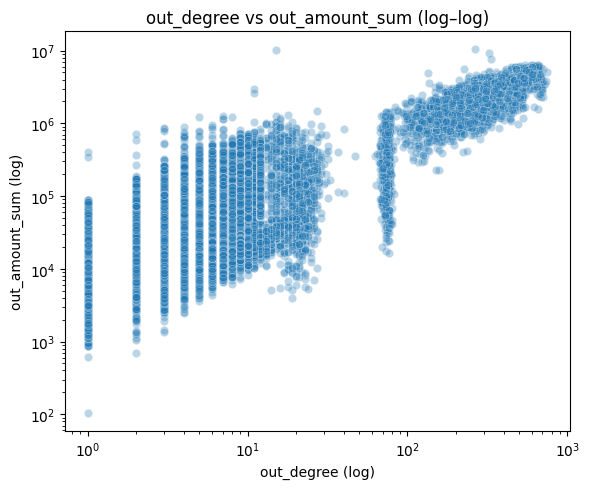

In [18]:
active_out_df = node_metrics_df.filter(
    (F.col("out_degree") > 0) & (F.col("out_amount_sum") > 0)
)

active_out_pd = active_out_df.select(
    "out_degree", "out_amount_sum"
).toPandas()

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=active_out_pd.sample(frac=0.2, random_state=42),  # sub-muestra para no saturar
    x="out_degree",
    y="out_amount_sum",
    alpha=0.3
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("out_degree (log)")
plt.ylabel("out_amount_sum (log)")
plt.title("out_degree vs out_amount_sum (log–log)")
plt.tight_layout()
plt.show()


Aquí se ve algo interesante que contrasta un poco con lo definido anteriormente. A grandes razgos la tendencia es: a mayor cantidad de transacciones mayor el volumen. No sorprende desde un punto de vista básico, quien envía muchas transacciones suele mover más plata en total. Ahora, la nube se dispersa hacia los grados bajos y se densifica hacia los grados medios en la primera mitad. Con los grados altos se tiene algo interesante. Primero, se separan del resto, casi como mostrando un clúster diferente, incluso un subclúster cercano a 10². Tal vez es la línea divisoria entre ricos y pobres, pero esto es solo una conjetura. Se supone que estos datos son sintéticos, pero tal vez el método de generación tiene de alguna forma este patrón. No se puede descartar que se esté viendo tampoco una clara señal de fraudulencia. 

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

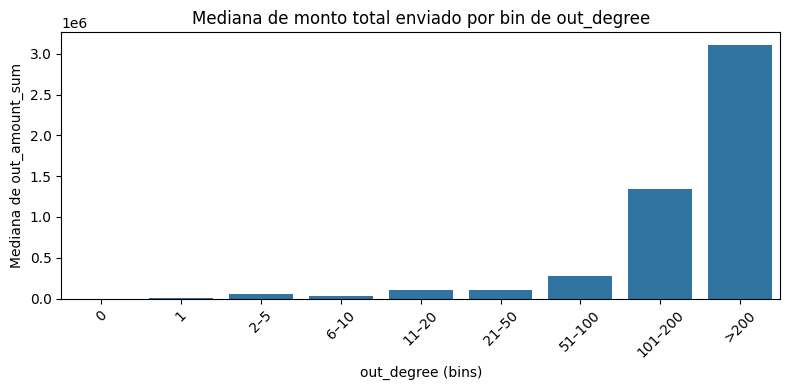

In [19]:
# Usamos los mismos bins de out_degree que definimos antes
deg_bins_order = ["0", "1", "2–5", "6–10", "11–20", "21–50", "51–100", "101–200", ">200"]

node_binned_df = (
    node_metrics_df
    .transform(lambda df: add_degree_bins(df, "out_degree", "out_degree_bin"))
)

# media y mediana de montos por bin
amount_by_bin = (
    node_binned_df
    .groupBy("out_degree_bin")
    .agg(
        F.count("*").alias("n_nodes"),
        F.mean("out_amount_sum").alias("mean_out_amount_sum"),
        F.expr("percentile(out_amount_sum, 0.5)").alias("median_out_amount_sum")
    )
)

amount_by_bin_pd = amount_by_bin.toPandas()
amount_by_bin_pd["out_degree_bin"] = pd.Categorical(
    amount_by_bin_pd["out_degree_bin"],
    categories=deg_bins_order,
    ordered=True
)
amount_by_bin_pd = amount_by_bin_pd.sort_values("out_degree_bin")

plt.figure(figsize=(8,4))
sns.barplot(
    data=amount_by_bin_pd,
    x="out_degree_bin",
    y="median_out_amount_sum"
)
plt.xticks(rotation=45)
plt.xlabel("out_degree (bins)")
plt.ylabel("Mediana de out_amount_sum")
plt.title("Mediana de monto total enviado por bin de out_degree")
plt.tight_layout()
plt.show()


Y bueno, este gráfico es la prueba cuantitativa de lo que se veía con el scatter. A medida que más dinero posee una cuenta mucho mayor el el flujo neto que ésta puede mover. 

## Bivariado 2 monto vs fraude

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

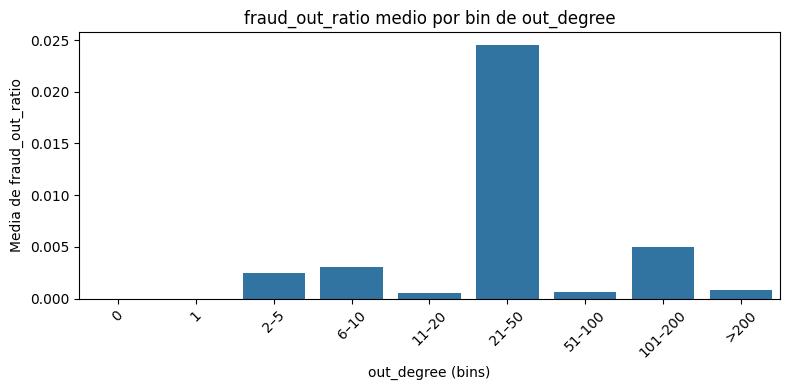

In [20]:
#fraud_out_ratio por bin de grado
fraud_by_deg = (
    node_binned_df
    .groupBy("out_degree_bin")
    .agg(
        F.count("*").alias("n_nodes"),
        F.mean("fraud_out_ratio").alias("mean_fraud_out_ratio"),
        F.expr("percentile(fraud_out_ratio, 0.75)").alias("p75_fraud_out_ratio")
    )
)

fraud_by_deg_pd = fraud_by_deg.toPandas()
fraud_by_deg_pd["out_degree_bin"] = pd.Categorical(
    fraud_by_deg_pd["out_degree_bin"],
    categories=deg_bins_order,
    ordered=True
)
fraud_by_deg_pd = fraud_by_deg_pd.sort_values("out_degree_bin")

plt.figure(figsize=(8,4))
sns.barplot(
    data=fraud_by_deg_pd,
    x="out_degree_bin",
    y="mean_fraud_out_ratio"
)
plt.xticks(rotation=45)
plt.xlabel("out_degree (bins)")
plt.ylabel("Media de fraud_out_ratio")
plt.title("fraud_out_ratio medio por bin de out_degree")
plt.tight_layout()
plt.show()


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

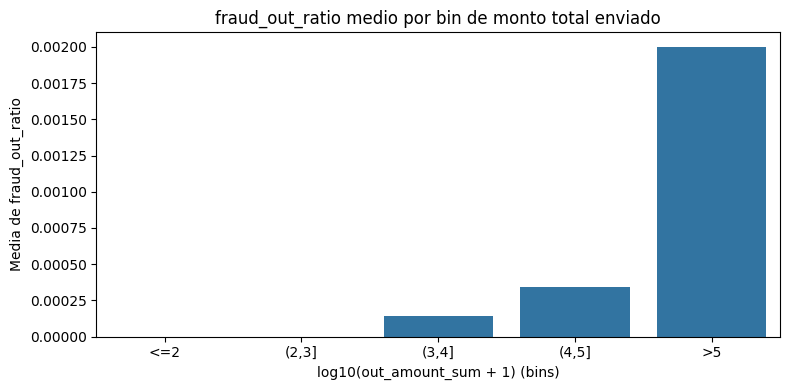

In [21]:
#fraud_out_ratio por bin de monto
# Bins de log montos
node_metrics_df = node_metrics_df.withColumn(
    "log_out_amount_bin",
    F.when(F.col("log_out_amount_sum") <= 2, "<=2")         # hasta ~100
     .when(F.col("log_out_amount_sum") <= 3, "(2,3]")      # ~100–1000
     .when(F.col("log_out_amount_sum") <= 4, "(3,4]")      # ~1k–10k
     .when(F.col("log_out_amount_sum") <= 5, "(4,5]")      # ~10k–100k
     .otherwise(">5")                                      # >100k
)

fraud_by_amount = (
    node_metrics_df
    .groupBy("log_out_amount_bin")
    .agg(
        F.count("*").alias("n_nodes"),
        F.mean("fraud_out_ratio").alias("mean_fraud_out_ratio")
    )
)

fraud_by_amount_pd = fraud_by_amount.toPandas()
amount_order = ["<=2", "(2,3]", "(3,4]", "(4,5]", ">5"]
fraud_by_amount_pd["log_out_amount_bin"] = pd.Categorical(
    fraud_by_amount_pd["log_out_amount_bin"],
    categories=amount_order,
    ordered=True
)
fraud_by_amount_pd = fraud_by_amount_pd.sort_values("log_out_amount_bin")

plt.figure(figsize=(8,4))
sns.barplot(
    data=fraud_by_amount_pd,
    x="log_out_amount_bin",
    y="mean_fraud_out_ratio"
)
plt.xlabel("log10(out_amount_sum + 1) (bins)")
plt.ylabel("Media de fraud_out_ratio")
plt.title("fraud_out_ratio medio por bin de monto total enviado")
plt.tight_layout()
plt.show()


Aquí la relación es más directa. Cuanto mayor es el volumen enviado por la cuenta mayor es la fracción de sus transacciones que son fraude. Se trata de otro patrón fácil de señalar para efectuar eventual clasificación nodal de fraude. 

# Conectividad y componentes

In [43]:
from py2neo import Graph

## Weakly Connected Components (WCC): estructura global

In [51]:
graph = Graph(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASS), name=NEO4J_DDBB)

In [52]:
# Proyección no dirigida para WCC
graph.run("""
CALL gds.graph.project(
  'aml_wcc',
  'Account',
  {
    TX: {
      type: 'TX',
      orientation: 'UNDIRECTED'
    }
  }
);""").data()

# Ejecutar WCC y escribir el id de componente en cada nodo
graph.run("""
CALL gds.wcc.write(
  'aml_wcc',
  {
    writeProperty: 'wcc_id'
  }
);""").data()


ConnectionBroken: Failed to read message

In [47]:
graph.run("""
CALL dbms.procedures()
YIELD name
WHERE name STARTS WITH 'gds'
RETURN name
LIMIT 1
""").data()


[{'n': Node('Account', account_number=4651102136, current_balance=51445.619999999995, first_seen=DateTime(2023, 3, 18, 0, 35, 31.0), last_seen=DateTime(2023, 3, 18, 21, 45, 28.0), location='UK', **{'mclose_2023_03_UK pounds': 51445.619999999995})}]

In [48]:
NEO4J_USER

'neo4j'

In [49]:
NEO4J_PASS

'Banco.69'

In [24]:
# Cargar membership de componentes desde Neo4j
df_wcc = (
    spark.read.format("org.neo4j.spark.DataSource")
    .options(**opts)  # mismo dict de opciones que ya usas
    .option(
        "query",
        """
        MATCH (a:Account)
        RETURN a.account_id AS account_id,
               a.wcc_id     AS wcc_id
        """
    )
    .load()
)

# Número total de nodos con componente asignada
n_nodes = df_wcc.count()

# Tamaño de cada componente (en número de nodos)
df_wcc_sizes = (
    df_wcc.groupBy("wcc_id")
    .agg(F.count("*").alias("num_nodes"))
    .orderBy(F.desc("num_nodes"))
)

df_wcc_sizes.show(10, truncate=False)
print("Total de nodos con wcc_id:", n_nodes)


[Stage 132:>                                                        (0 + 1) / 1]

+------+---------+
|wcc_id|num_nodes|
+------+---------+
|NULL  |855460   |
+------+---------+

Total de nodos con wcc_id: 855460


In [25]:
#Stats agregados
# Total de componentes
n_components = df_wcc_sizes.count()

# Tamaño del componente gigante
giant_row = df_wcc_sizes.first()
giant_size = giant_row["num_nodes"]
frac_nodes_giant = giant_size / n_nodes

print(f"N° componentes WCC: {n_components}")
print(f"Tamaño componente gigante: {giant_size} nodos ({frac_nodes_giant:.2%} del total)")


[Stage 141:>                                                        (0 + 1) / 1]

N° componentes WCC: 1
Tamaño componente gigante: 855460 nodos (100.00% del total)


In [31]:
wcc_hist = (
    df_wcc_sizes
    .withColumn(
        "size_bin",
        F.when(F.col("num_nodes") == 1, "1")
         .when(F.col("num_nodes") <= 5, "2-5")
         .when(F.col("num_nodes") <= 20, "6-20")
         .when(F.col("num_nodes") <= 100, "21-100")
         .otherwise("100+")
    )
    .groupBy("size_bin")
    .agg(
        F.count("*").alias("num_components"),
        F.sum("num_nodes").alias("total_nodes_in_bin")
    )
    .orderBy("size_bin")
)

wcc_hist.toPandas()


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,size_bin,num_components,total_nodes_in_bin
0,100+,1,855460


[Stage 150:>  (0 + 1) / 1][Stage 156:>  (0 + 1) / 1][Stage 162:>  (0 + 1) / 1]

In [32]:
#Cruce con fraude
# Asegúrate de tener edges_df con src/dst = account_id
# edges_df.printSchema()

edges_with_comp = (
    edges_df.alias("e")
    .join(df_wcc.alias("s"), F.col("e.src") == F.col("s.account_id"))
    .withColumnRenamed("wcc_id", "wcc_src")
    .join(df_wcc.alias("t"), F.col("e.dst") == F.col("t.account_id"))
    .withColumnRenamed("wcc_id", "wcc_dst")
)

# Por definición de WCC, wcc_src y wcc_dst deberían coincidir siempre
mismatches = edges_with_comp.filter(F.col("wcc_src") != F.col("wcc_dst")).count()
print("Aristas con src y dst en distinta WCC (debería ser 0):", mismatches)

# Aristas por componente + fraude
df_wcc_edges = (
    edges_with_comp
    .groupBy("wcc_src")
    .agg(
        F.count("*").alias("num_edges"),
        F.sum(F.col("is_laundering").cast("int")).alias("num_fraud_edges")
    )
    .withColumnRenamed("wcc_src", "wcc_id")
)

# Unir con tamaños de componente
wcc_summary = (
    df_wcc_sizes.join(df_wcc_edges, "wcc_id", "left")
    .fillna(0, subset=["num_edges", "num_fraud_edges"])
    .withColumn("fraud_edge_ratio", F.col("num_fraud_edges") / F.col("num_edges"))
    .orderBy(F.desc("num_nodes"))
)

wcc_summary.toPandas()


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Aristas con src y dst en distinta WCC (debería ser 0): 0


,wcc_id,num_nodes,num_edges,num_fraud_edges,fraud_edge_ratio
0,None,855460,0,0,NaN


[Stage 150:>  (0 + 1) / 1][Stage 156:>  (0 + 1) / 1][Stage 162:>  (0 + 1) / 1]

In [33]:
#Resumen
total_fraud_edges = wcc_summary.agg(F.sum("num_fraud_edges")).first()[0]

top10 = wcc_summary.limit(10)
top10_fraud = top10.agg(F.sum("num_fraud_edges")).first()[0]

print(f"Fraude total (aristas): {total_fraud_edges}")
if total_fraud_edges > 0:
    print(f"Fraude dentro de las 10 WCC más grandes: {top10_fraud} "
      f"({top10_fraud/total_fraud_edges:.2%})")


[Stage 200:>  (0 + 1) / 1][Stage 208:>  (0 + 1) / 1][Stage 209:>  (0 + 1) / 1]  

Fraude total (aristas): 0


[Stage 200:>                (0 + 1) / 1][Stage 209:>                (0 + 1) / 1]

## Strongly Connected Components (SCC): ciclos y feedback

In [ ]:
# // Proyección dirigida
# CALL gds.graph.project(
#   'aml_scc',
#   'Account',
#   'TX'
# );

# // SCC dirigida
# CALL gds.scc.write(
#   'aml_scc',
#   {
#     writeProperty: 'scc_id'
#   }
# );


In [39]:
df_scc = (
    spark.read.format("org.neo4j.spark.DataSource")
    .options(**opts)
    .option(
        "query",
        """
        MATCH (a:Account)
        RETURN a.account_id AS account_id,
               a.scc_id     AS scc_id
        """
    )
    .load()
)

df_scc_sizes = (
    df_scc.groupBy("scc_id")
    .agg(F.count("*").alias("num_nodes"))
    .orderBy(F.desc("num_nodes"))
)

print(df_scc_sizes.toPandas())

n_scc = df_scc_sizes.count()
print("N° de SCC:", n_scc)


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

  scc_id  num_nodes
0   None     855460


[Stage 268:>                                                        (0 + 1) / 1]

N° de SCC: 1


In [40]:
# SCC de tamaño 1 (sin ciclos no triviales)
df_scc_size1 = df_scc_sizes.filter(F.col("num_nodes") == 1)
# SCC no triviales (>=2 nodos)
df_scc_big = df_scc_sizes.filter(F.col("num_nodes") >= 2)

print("SCC tamaño 1:", df_scc_size1.count())
print("SCC tamaño >=2:", df_scc_big.count())


SCC tamaño 1: 0


[Stage 280:>                                                        (0 + 1) / 1]

SCC tamaño >=2: 1


In [41]:
nodes_in_nontrivial_scc = df_scc_big.agg(F.sum("num_nodes")).first()[0]
print("Nodos en SCC no triviales:", nodes_in_nontrivial_scc)


[Stage 286:>                                                        (0 + 1) / 1]

Nodos en SCC no triviales: 855460


In [42]:
#SSC + fraude
edges_with_scc = (
    edges_df.alias("e")
    .join(df_scc.alias("s"), F.col("e.src") == F.col("s.account_id"))
    .withColumnRenamed("scc_id", "scc_src")
    .join(df_scc.alias("t"), F.col("e.dst") == F.col("t.account_id"))
    .withColumnRenamed("scc_id", "scc_dst")
)

# Nos interesan aristas dentro de la misma SCC (ciclos internos)
edges_in_scc = edges_with_scc.filter(F.col("scc_src") == F.col("scc_dst"))

scc_fraud_summary = (
    edges_in_scc
    .groupBy("scc_src")
    .agg(
        F.count("*").alias("num_edges"),
        F.sum(F.col("is_laundering").cast("int")).alias("num_fraud_edges")
    )
    .withColumnRenamed("scc_src", "scc_id")
    .join(df_scc_big, "scc_id", "inner")  # solo SCC >=2 nodos
    .withColumn("fraud_edge_ratio", F.col("num_fraud_edges") / F.col("num_edges"))
    .orderBy(F.desc("fraud_edge_ratio"))
)

scc_fraud_summary.toPandas()


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
[Stage 292:>  (0 + 1) / 1][Stage 293:>  (0 + 1) / 1][Stage 294:>  (0 + 1) / 1]1]

,scc_id,num_edges,num_fraud_edges,num_nodes,fraud_edge_ratio


[Stage 292:>                                                        (0 + 1) / 1]

Se puede inferir que este set de datos está completamente conectado. No se observan islas, lo cual parece raro, pero dada la naturaleza sintética de los datos no será cuestionada

# Centralidades (degree, betweenness, PageRank…)

# Comunidades y “subredes calientes”

# Motifs y patrones AML clásicos

Dado que es AML, te interesan patrones como:

Cadenas: A → B → C → D

Fan-in: muchos emisores → 1 receptor

Fan-out: 1 emisor → muchos receptores

Ciclos: A → B → C → A (o con cambios de moneda).

# De EDA topológico a features y clasificación nodal